In [1]:
cd /home

/home


In [2]:
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np
import pickle
import json
import os

from sklearn.metrics import r2_score, mean_squared_error

from core.astromer import get_ASTROMER, train, predict
from core.data  import pretraining_records

from tensorboard.backend.event_processing import event_accumulator
from tensorflow.core.util import event_pb2
from tensorflow.python.lib.io import tf_record


%load_ext autoreload
%autoreload 2

os.environ["CUDA_VISIBLE_DEVICES"] = "2"

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})
# for Palatino and other serif fonts use:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
})


In [3]:
def my_summary_iterator(path):
    for r in tf_record.tf_record_iterator(path):
        yield event_pb2.Event.FromString(r)
        
def get_metrics(path_logs):
    train_logs = [x for x in os.listdir(path_logs) if x.endswith('.v2')][-1]

    path_train = os.path.join(path_logs, train_logs)

    ea = event_accumulator.EventAccumulator(path_train,  size_guidance={'tensors': 0})
    ea.Reload()   

    metrics = pd.DataFrame([(w,s,tf.make_ndarray(t))for w,s,t in ea.Tensors('mse')],
                columns=['wall_time', 'step', 'value'])
    return metrics

In [4]:
exp_path = './runs/astromer_256/'

Text(0.04, 0.5, 'Root-mean-square error')

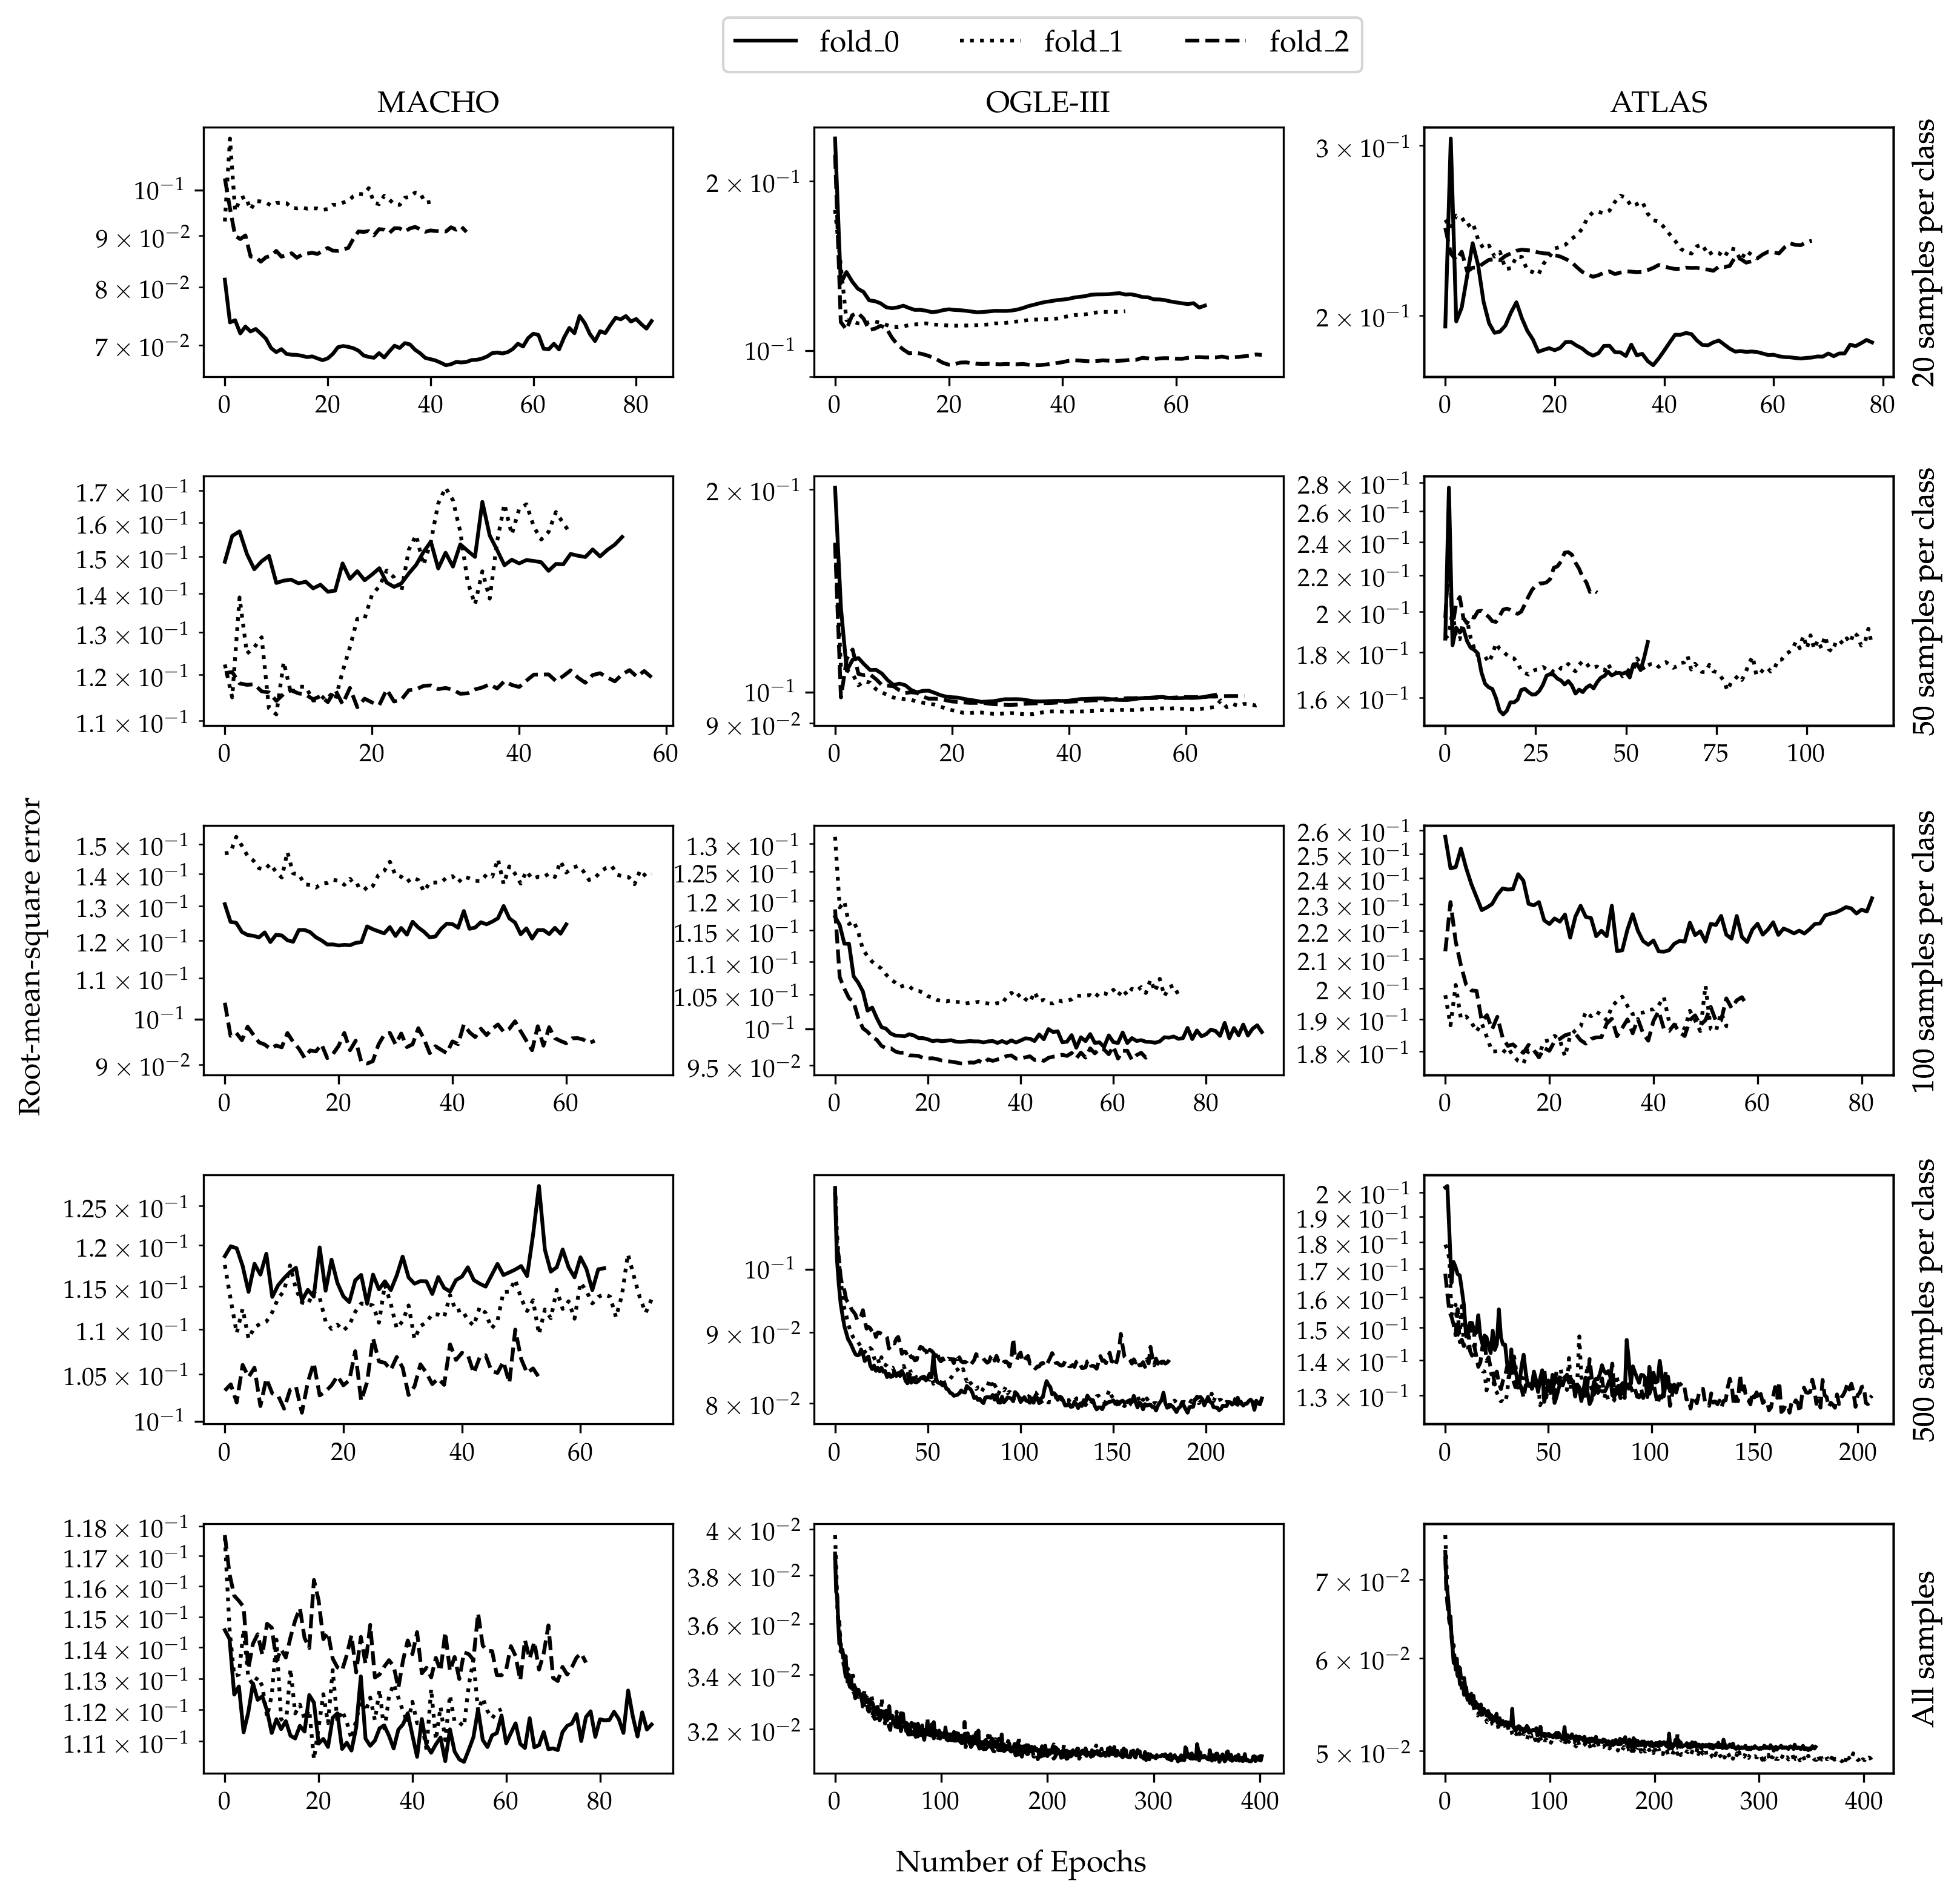

In [7]:
fig, axes = plt.subplots(5,3, figsize=(12,12), dpi=300, gridspec_kw={'hspace': 0.4, 'wspace': 0.3})
ls = ['-', ':', '--']
for col, dataset in enumerate(['alcock','ogle', 'atlas']):
    values = []
    for row, subset in enumerate([20, 50, 100, 500, -1]):
        for fold in range(3):
            if subset != -1:
                subset_name = '{}_{}'.format(dataset, subset)
            else:
                subset_name = dataset
                
            if '_' in subset_name:           
                path = os.path.join(exp_path, 'ab',dataset, 'fold_{}'.format(fold), subset_name, 'logs', 'valid')
            else:
                path = os.path.join(exp_path, 'c',dataset, 'fold_{}'.format(fold), subset_name, 'logs', 'valid')
                
            metrc = get_metrics(path)

            lowest_rmse = metrc['value'].min()

            x = metrc['step']
            axes[row][col].plot(x, metrc['value'], label='fold_{}'.format(fold), color='k', linestyle=ls[fold])
            
            axes[row][col].set_yscale('log')
            
            if col == 2:
                if subset == -1:
                    ax2 = axes[row][col].twinx() 
                    ax2.set_ylabel('All samples', fontsize=12)
                    ax2.set_yticks([])
                else:
                    ax2 = axes[row][col].twinx() 
                    ax2.set_ylabel('{} samples per class'.format(subset), fontsize=12)
                    ax2.set_yticks([])
                    
            if row == 0 and dataset == 'alcock':
                axes[row][col].set_title('MACHO')
                
            if row == 0 and dataset == 'ogle':
                axes[row][col].set_title('OGLE-III')
                
            if row == 0 and dataset == 'atlas':
                axes[row][col].set_title('ATLAS')
                
            values.append([metrc['value'].min(), metrc['value'].max()])
    
axes[0][1].legend(ncol=3, bbox_to_anchor = (1.2, 1.5), fontsize=12)
fig.text(0.5, 0.08, 'Number of Epochs', ha='center', fontsize=12)
fig.text(0.04, 0.5, 'Root-mean-square error', va='center', rotation='vertical', fontsize=12)

In [8]:
fig.savefig('presentation/figures/ft_val_curves.pdf', format='pdf', bbox_inches='tight')

## Training Times

In [230]:
intervals = (
    ('weeks', 604800),  # 60 * 60 * 24 * 7
    ('days', 86400),    # 60 * 60 * 24
    ('hours', 3600),    # 60 * 60
    ('minutes', 60),
    ('seconds', 1),
)

def display_time(seconds, granularity=2):
    result = []

    for name, count in intervals:
        value = seconds // count
        if value:
            seconds -= value * count
            if value == 1:
                name = name.rstrip('s')
            result.append("{} {}".format(value, name))
    return ', '.join(result[:granularity])

In [173]:
for col, dataset in enumerate(['alcock','ogle', 'atlas']):
    values = []
    for row, subset in enumerate([ -1]):
        times = []
        rmse_list = []
        for fold in range(3):
            if subset != -1:
                subset_name = '{}_{}'.format(dataset, subset)
            else:
                subset_name = dataset
                
            if '_' in subset_name:           
                path = os.path.join(exp_path, 'ab',dataset, 'fold_{}'.format(fold), subset_name, 'logs', 'valid')
            else:
                path = os.path.join(exp_path, 'c',dataset, 'fold_{}'.format(fold), subset_name, 'logs', 'valid')
                
            metrc = get_metrics(path)
            time = metrc['wall_time'].iloc[-1] - metrc['wall_time'].iloc[0]
            rmse_list.append(metrc['value'].min())
            times.append(time)
        print(dataset, display_time(np.mean(times)), '{:.2f}'.format(np.mean(rmse_list)))

alcock 23.0 minutes, 3.0 seconds 0.11
ogle 1.0 day, 8.0 hours 0.03
atlas 9.0 hours, 58.0 minutes 0.05


## Testing RMSE on finetuned models

Testing all the models is time consuming! `subset_ft.pkl` already has all the results

In [4]:
try:
    with open('./presentation/backup/subset_ft.pkl', 'rb') as handle:
        res_dic = pickle.load(handle)
except Exception as e:
    print(e)
    res_dic = {'alcock':{'mean':[], 'std':[]}, 'ogle':{'mean':[], 'std':[]}, 'atlas':{'mean':[], 'std':[]}}
    for col, dataset in enumerate(['alcock','ogle', 'atlas']):
        values, values_std = [], []
        for row, subset in enumerate([20, 50, 100, 500, -1]):
            times = []
            rmse_list = []
            for fold in range(3):
                if subset != -1:
                    subset_name = '{}_{}'.format(dataset, subset)
                else:
                    subset_name = dataset

                if '_' in subset_name:           
                    path = os.path.join(exp_path, 'ab',dataset, 'fold_{}'.format(fold), subset_name)
                else:
                    path = os.path.join(exp_path, 'c',dataset, 'fold_{}'.format(fold), subset_name)


                conf_file = os.path.join(path, 'conf.json')

                with open(conf_file, 'r') as handle:
                    conf = json.load(handle)

                dataset_path = os.path.join('./data/records/', dataset, 'fold_{}'.format(fold), '{}_20'.format(dataset))
                test_batches = pretraining_records(os.path.join(dataset_path, 'test'), 
                                            256, 
                                            max_obs=conf['max_obs'],
                                            msk_frac=conf['msk_frac'],
                                            rnd_frac=conf['rnd_frac'],
                                            same_frac=conf['same_frac'],
                                            sampling=False, shuffle=False)


                astromer = get_ASTROMER(num_layers=conf['layers'],
                            d_model=conf['head_dim'],
                            num_heads=conf['heads'],
                            dff=conf['dff'],
                            base=conf['base'],
                            use_leak=conf['use_leak'],
                            dropout=conf['dropout'],
                            maxlen=conf['max_obs'])


                weights_path = os.path.join(path, 'weights')
                astromer.load_weights(weights_path)

                result = predict(astromer, test_batches, conf)
                rmse_list.append(result['mse'])

            values.append(np.mean(rmse_list))
            values_std.append(np.std(rmse_list))
        res_dic[dataset]['mean'] =  values
        res_dic[dataset]['std'] =  values_std
    with open('./presentation/backup/subset_ft.pkl', 'wb') as h:
        pickle.dump(res_dic, h)

alcock [0.1097377  0.10666344 0.10878623 0.10471207 0.09476293]
ogle [0.087459   0.08507907 0.0828257  0.07447947 0.06177234]
atlas [0.2053613  0.18972848 0.17527956 0.1496656  0.07305571]


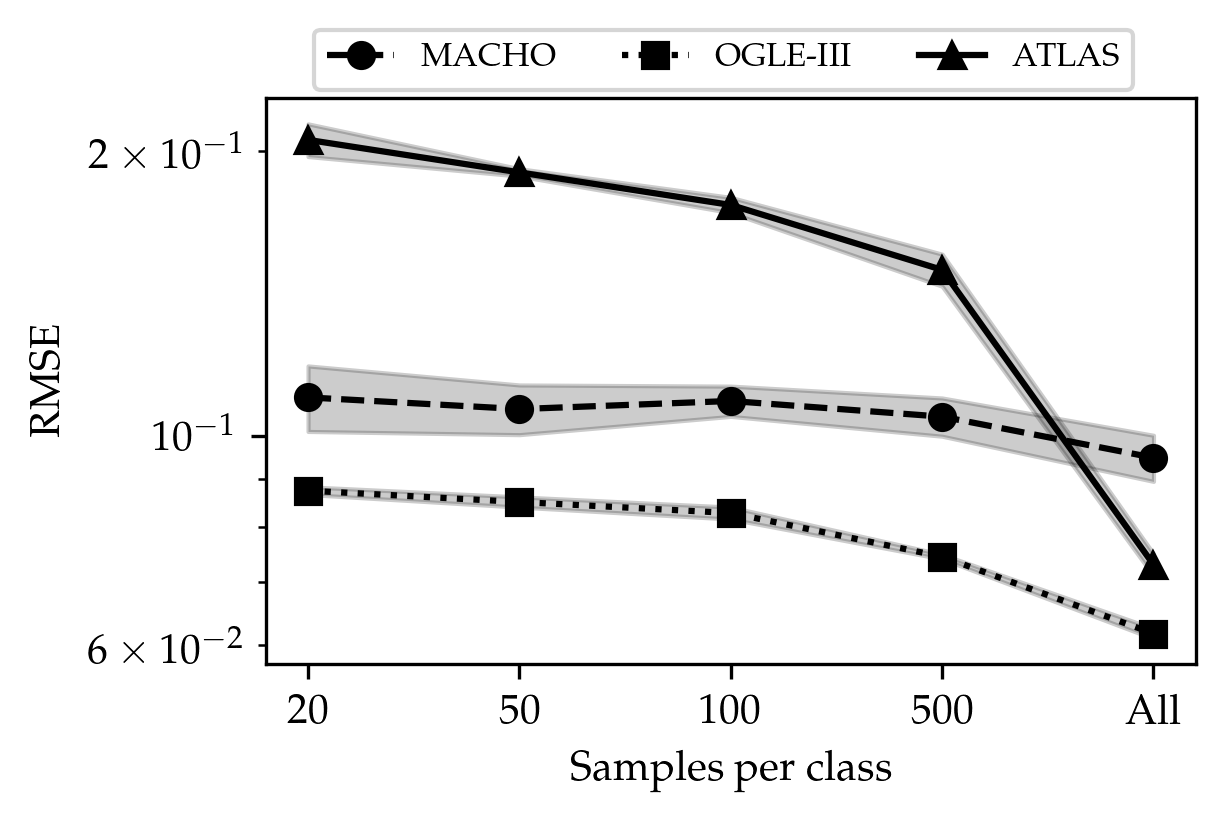

In [6]:
markers = ['o', 's', '^']
ls = ['--', ':', '-']
plt.figure(figsize=(4,2.5), dpi=300)
for col, dataset in enumerate(['alcock','ogle', 'atlas']):
    values = res_dic[dataset]['mean']
    values_std = res_dic[dataset]['std']
    
    if dataset == 'alcock':
        ds_name = 'MACHO'
    if dataset == 'ogle':
        ds_name = 'OGLE-III'
    if dataset == 'atlas':
        ds_name = 'ATLAS'
    
    values = np.array(values)
    print(dataset, values)
    values_std = np.array(values_std)
    x_range = np.arange(len(values))
    plt.plot(x_range, values, marker=markers[col], color='k', label=ds_name, linestyle=ls[col])
    plt.fill_between(x_range, values+values_std, values-values_std, color='k', alpha=0.2)
    plt.xticks(x_range, ['20', '50', '100', '500', 'All'])
plt.ylabel('RMSE')
plt.xlabel('Samples per class')
plt.yscale('log')
plt.legend(ncol=3, bbox_to_anchor = (.95, 1.15), fontsize=8)
# plt.savefig('./presentation/figures/subset_ft_rmse.pdf', format='pdf',bbox_inches='tight')

## Comparing Head-dim

In [200]:
wights_path = './weights/macho_{}'

In [201]:
for head_dim in [64, 128, 256]:
    path = os.path.join(wights_path.format(head_dim), 'logs', 'valid')
    metrc = get_metrics(path)
    print(metrc['value'].min())

0.15185417
0.15613385
0.1474126
